# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.1          # Binary Label Noise probability
disc_factor = np.pi/2    # Similarity of Y_sen to X
n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.1                # Cost of performance and fairness (Eq. 15 )
c_bar = 0.1  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= 2
lmd_end= 15
lmd_interval = np.linspace(lmd_start, lmd_end, 30)
symmetric_fairness = True

## 3. Data Generation

In [3]:
X, Y, Y_sen = generate_synthetic_data(False, n_samples, disc_factor, rnd_seed)
Y_corrupted = add_bin_noise(Y, flip_prob, rnd_seed)
Y_sen_corrupted = add_bin_noise(Y_sen, flip_prob, rnd_seed)

## 4. Model Training

In [4]:
# Split data
split_index = int(split_ratio * len(X))
X_train, X_test =                   X[:split_index],            X[split_index:]
Y_train, Y_test =                   Y[:split_index],            Y[split_index:]
Y_corr_train, Y_corr_test =         Y_corrupted[:split_index],  Y_corrupted[split_index:]
Y_sen_train, Y_sen_test =           Y_sen[:split_index],        Y_sen[split_index:]
Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

# Initialize and train models
p_reg = LogisticRegression().fit(X_train, Y_train)
p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression().fit(X_train, Y_sen_corr_train)

## 5. Visualization of Decision Boundaries

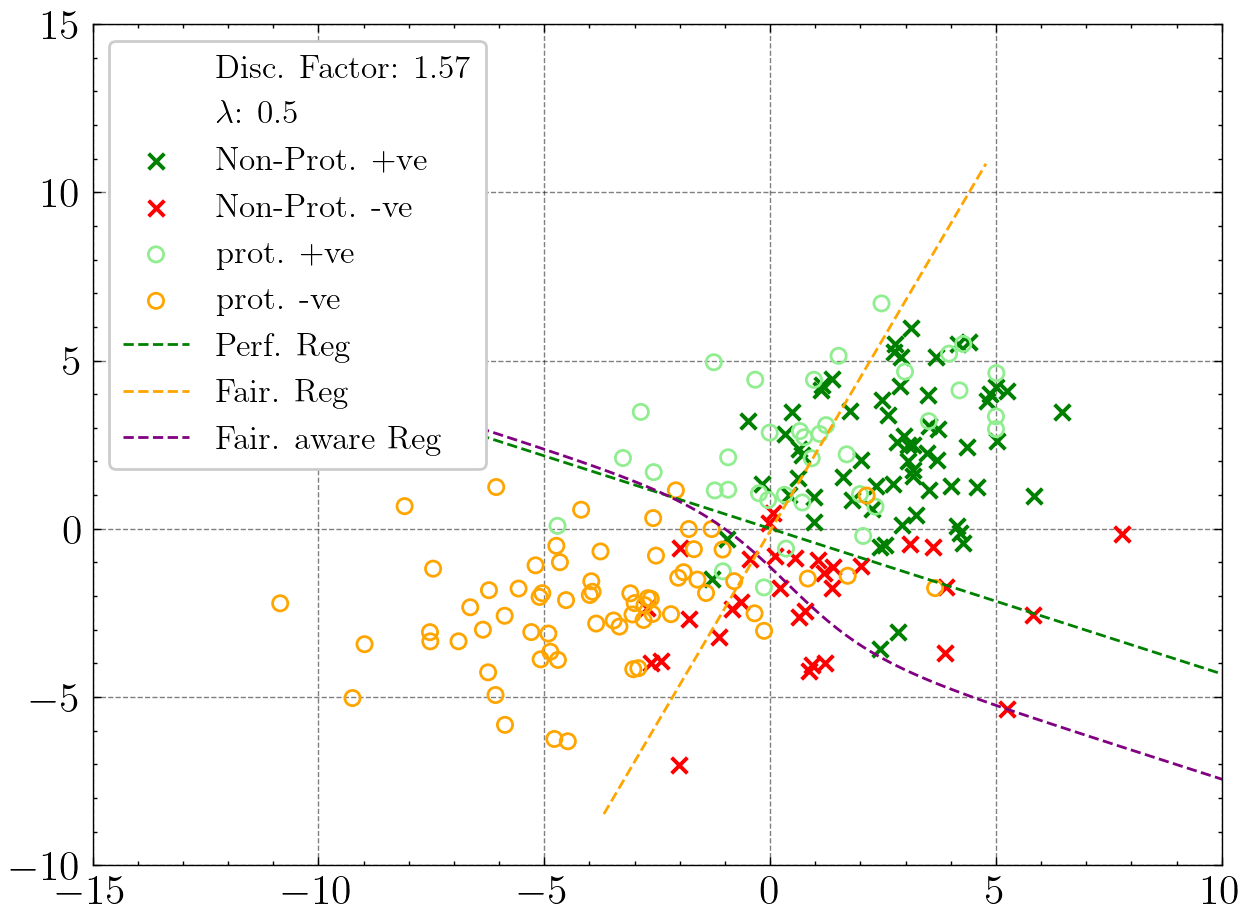

In [5]:
num_to_draw = 200 # we will only draw a small number of points to avoid clutter
x_draw = X[:num_to_draw]
y_draw = Y[:num_to_draw]
Y_sen_draw = Y_sen[:num_to_draw]

X_s_0 = x_draw[Y_sen_draw == 0.0]
X_s_1 = x_draw[Y_sen_draw == 1.0]
y_s_0 = y_draw[Y_sen_draw == 0.0]
y_s_1 = y_draw[Y_sen_draw == 1.0]


# Create a mesh grid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid_points = np.c_[xx.ravel(), yy.ravel()] #(N, 2)

# Predict probabilities for each point on the grid
Y_pred_p = p_reg.predict_proba(grid_points)[:, 1]
Y_pred_p = Y_pred_p.reshape(xx.shape)

Y_pred_f = f_reg.predict_proba(grid_points)[:, 1]
Y_pred_f = Y_pred_f.reshape(xx.shape)
 
Y_pred_all = p_reg.predict_proba(grid_points)[:, 1] - c - lmd * (f_reg.predict_proba(grid_points)[:, 1] - c_bar)
Y_pred_all = Y_pred_all.reshape(xx.shape)

plot_reg( Y_pred_p,Y_pred_f, Y_pred_all, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1, disc_factor, lmd)
#plt.savefig(f"img/Synth_Data_Zafar{df:.2f}_norm_scale.png")

## 6. Metric Calculation: BER and Fairness

In [6]:
lmd = -1
c = c_bar = 0.001
s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
#s = lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
# Apply step function H_a(z) with a = 0
Y_pred = np.where(s > 0, 1, 0)

BER = calc_BER(Y_pred, Y_test)
MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
print(BER,MD,DI)
Y_pred = np.where(s > 0, 1, 0)
print(np.sum(Y_pred))
print(len(Y_pred))

0.5 -0.0 1.0
1200
1200


/home/ptr@itd.local/code/fairness_triangle/tools/calc_metrics.py:43: RuntimeWarning: invalid value encountered in scalar divide
  DI_2 = FPR / (1-FNR)


In [7]:
# Sweep over lambda values and calculate metrics
BER_list = []
MD_list = []
DI_list = []
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []

# lmd = how important is fairness
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
    DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)


# Compute now with Corrupted labels
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred_2 = np.where(s_2 > 0, 1, 0)

    BER_2 = calc_BER(Y_pred_2, Y_test)
    MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
    DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
    
    BER_list_corr.append(BER_2)
    MD_list_corr.append(MD_2)
    DI_list_corr.append(DI_2)

In [8]:
# Store results in DataFrame
results = pd.DataFrame({
    'lambda': lmd_interval,
    'BER_clean': BER_list,
    'MD_clean': MD_list,
    'DI_clean': DI_list,
    'BER_corr': BER_list_corr,
    'MD_corr': MD_list_corr,
    'DI_corr': DI_list_corr
})

In [9]:
results

,lambda,BER_clean,MD_clean,DI_clean,BER_corr,MD_corr,DI_corr
0,2.000000,0.255934,-0.489340,0.446635,0.293024,-0.428280,0.533136
1,2.448276,0.285429,-0.443517,0.513017,0.319992,-0.377526,0.597172
2,2.896552,0.306447,-0.411390,0.553959,0.347788,-0.318453,0.665514
3,3.344828,0.313181,-0.397889,0.570138,0.378056,-0.261115,0.729031
4,3.793103,0.326637,-0.384249,0.589999,0.392340,-0.229155,0.762605
5,4.241379,0.343460,-0.353858,0.625727,0.406624,-0.200528,0.792970
6,4.689655,0.347699,-0.338676,0.643033,0.415907,-0.175234,0.820005
7,5.137931,0.360294,-0.310105,0.673147,0.425147,-0.160053,0.836156
8,5.586207,0.369555,-0.291534,0.694319,0.435236,-0.146496,0.851042
9,6.034483,0.373806,-0.269658,0.717746,0.444475,-0.127981,0.870086


/tmp/ipykernel_765672/838755183.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_765672/838755183.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


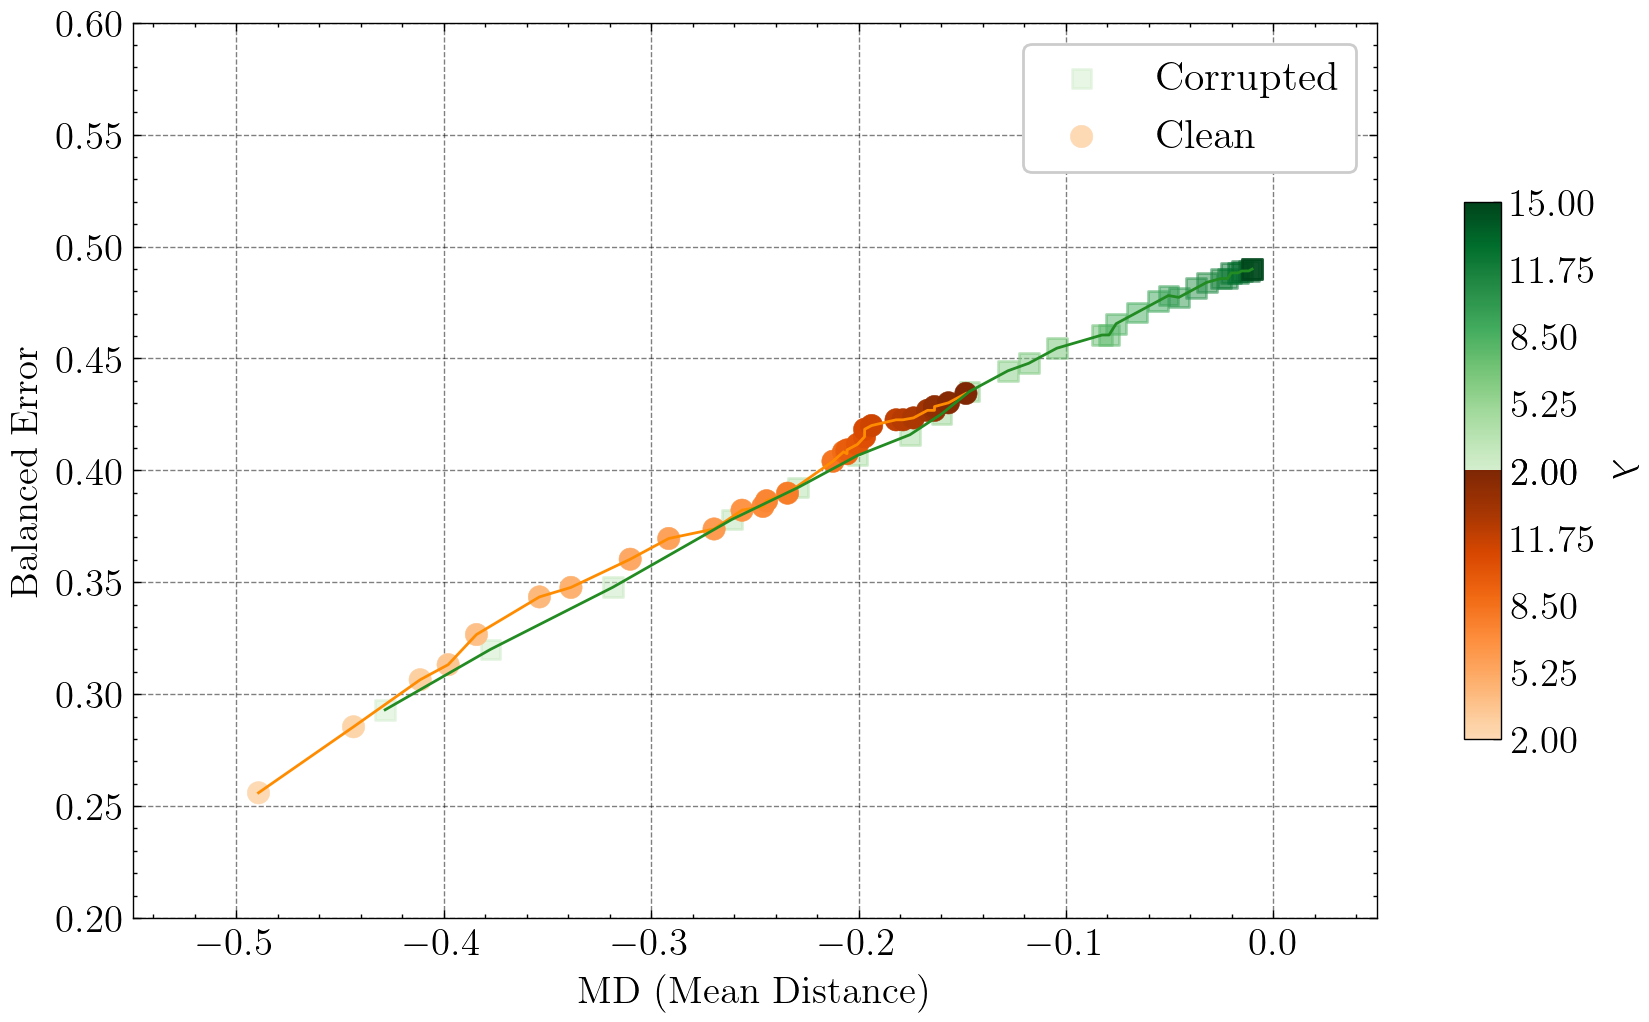

In [ ]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["MD_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["MD_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["MD_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["MD_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=65)
# Plot Corrupted data


# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)


cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("MD (Mean Distance)")
ax.set_ylabel("Balanced Error")
ax.set_xlim(-0.55, 0.05)
ax.set_ylim(0.2, 0.6)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

/tmp/ipykernel_765672/2688118335.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_765672/2688118335.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


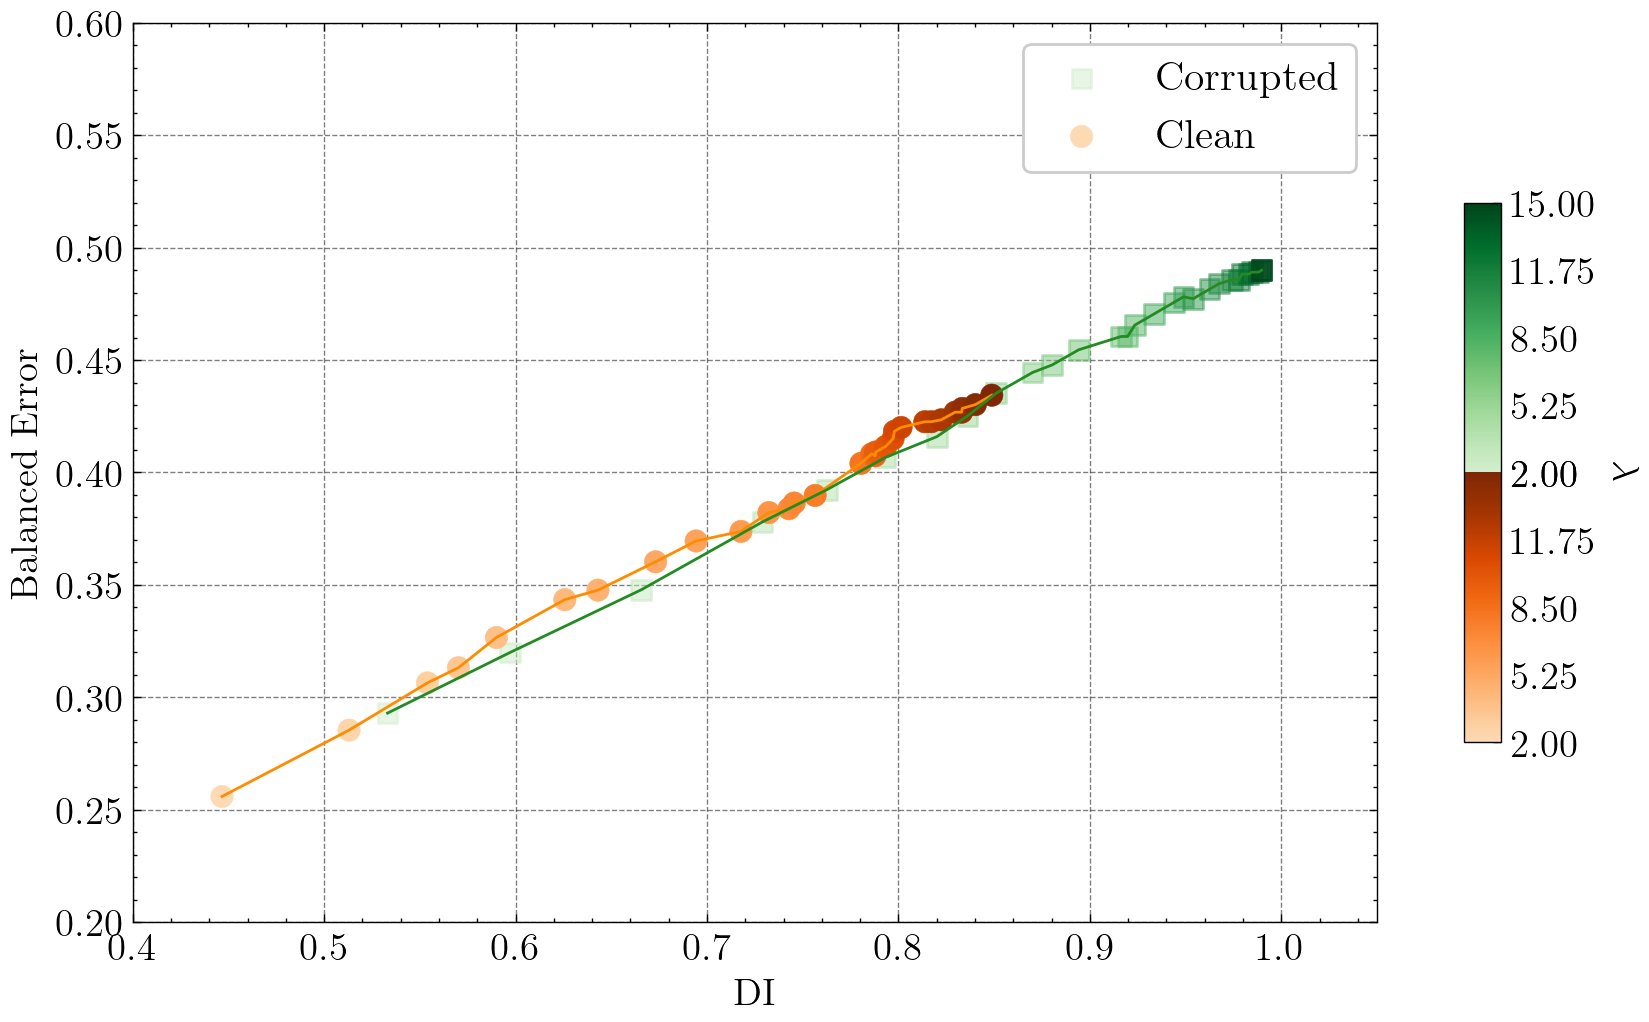

In [22]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["DI_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["DI_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["DI_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["DI_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=65)
# Plot Corrupted data



# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)




cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("DI" )
ax.set_ylabel("Balanced Error")
ax.set_xlim(0.4, 1.05)
ax.set_ylim(0.2, 0.6)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
